# SelectSwapQROM

In [ ]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `SelectSwapQROM`
Gate to load data[l] in the target register when the selection register stores integer l.

Let
    N:= Number of data elements to load.
    b:= Bit-length of the target register in which data elements should be loaded.

The `SelectSwapQROM` is a hybrid of the following two existing primitives:

    * Unary Iteration based `QROM` requires O(N) T-gates to load `N` data
    elements into a b-bit target register. Note that the T-complexity is independent of `b`.
    * `SwapWithZeroGate` can swap a `b` bit register indexed `x` with a `b`
    bit register at index `0` using O(b) T-gates, if the selection register stores integer `x`.
    Note that the swap complexity is independent of the iteration length `N`.

The `SelectSwapQROM` uses square root decomposition by combining the above two approaches to
further optimize the T-gate complexity of loading `N` data elements, each into a `b` bit
target register as follows:

    * Divide the `N` data elements into batches of size `B` (a variable) and
    load each batch simultaneously into `B` distinct target signature using the conventional
    QROM. This has T-complexity `O(N / B)`.
    * Use `SwapWithZeroGate` to swap the `i % B`'th target register in batch number `i / B`
    to load `data[i]` in the 0'th target register. This has T-complexity `O(B * b)`.

This, the final T-complexity of `SelectSwapQROM` is `O(B * b + N / B)` T-gates; where `B` is
the block-size with an optimal value of `O(sqrt(N / b))`.

This improvement in T-complexity is achieved at the cost of using an additional `O(B * b)`
ancilla qubits, with a nice property that these additional ancillas can be `dirty`; i.e.
they don't need to start in the |0> state and thus can be borrowed from other parts of the
algorithm. The state of these dirty ancillas would be unaffected after the operation has
finished.

For more details, see the reference below:

#### References
 - [Trading T-gates for dirty qubits in state preparation and unitary synthesis](https://arxiv.org/abs/1812.00954). Low, Kliuchnikov, Schaeffer. 2018.


In [ ]:
from qualtran.bloqs.data_loading.select_swap_qrom import SelectSwapQROM

### Example Instances

In [ ]:
data1 = np.arange(5)
data2 = np.arange(5) + 1
qroam_multi_data = SelectSwapQROM.build_from_data([data1, data2])

In [ ]:
data1 = np.arange(25).reshape((5, 5))
data2 = (np.arange(25) + 1).reshape((5, 5))
qroam_multi_dim = SelectSwapQROM.build_from_data([data1, data2])

In [ ]:
N, M, b1, b2, k1, k2, c = sympy.symbols('N M b1 b2 k1 k2 c')
log_block_sizes = (k1, k2)
qroam_symb_dirty = SelectSwapQROM.build_from_bitsize(
    (N, M), (b1, b2), log_block_sizes=log_block_sizes, num_controls=c
)

In [ ]:
N, M, b1, b2, k1, k2, c = sympy.symbols('N M b1 b2 k1 k2 c')
log_block_sizes = (k1, k2)
qroam_symb_clean = SelectSwapQROM.build_from_bitsize(
    (N, M), (b1, b2), log_block_sizes=log_block_sizes, num_controls=c, use_dirty_ancilla=False
)

#### Graphical Signature

In [ ]:
from qualtran.drawing import show_bloqs
show_bloqs([qroam_multi_data, qroam_multi_dim, qroam_symb_dirty, qroam_symb_clean],
           ['`qroam_multi_data`', '`qroam_multi_dim`', '`qroam_symb_dirty`', '`qroam_symb_clean`'])

### Call Graph

In [ ]:
from qualtran.resource_counting.generalizers import ignore_split_join
qroam_multi_data_g, qroam_multi_data_sigma = qroam_multi_data.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(qroam_multi_data_g)
show_counts_sigma(qroam_multi_data_sigma)

## Bloq counts of QROAM with dirty ancilla

[Qubitization of Arbitrary Basis Quantum Chemistry Leveraging Sparsity and Low Rank Factorization, Appendix-A](https://arxiv.org/abs/1902.02134)
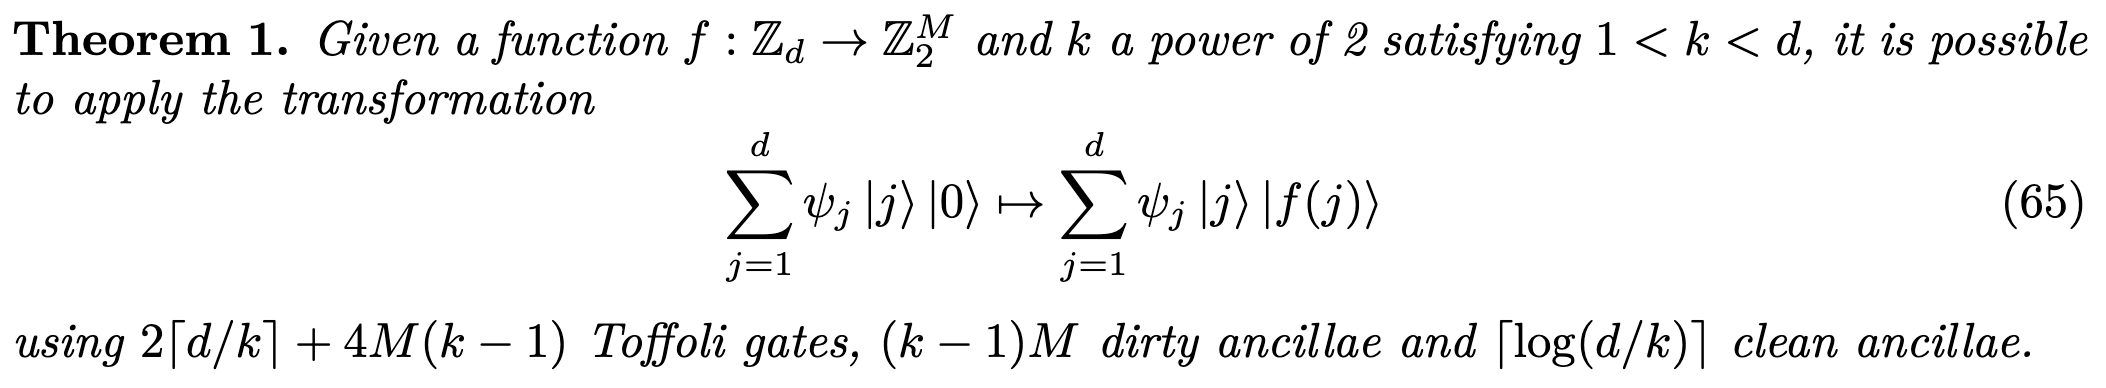

In [ ]:
from qualtran.bloqs.basic_gates import Toffoli
g, sigma = qroam_symb_dirty.call_graph()
show_counts_sigma(sigma)
# Total Toffoli counts obtained by summing up counts of T and T^{\daggar} gates.
show_counts_sigma({Toffoli(): (sigma[TGate()] + sigma[TGate().adjoint()]) / 4})

## Bloq counts of QROAM with clean ancilla
[Qubitization of Arbitrary Basis Quantum Chemistry Leveraging Sparsity and Low Rank Factorization, Appendix-B](https://arxiv.org/abs/1902.02134)
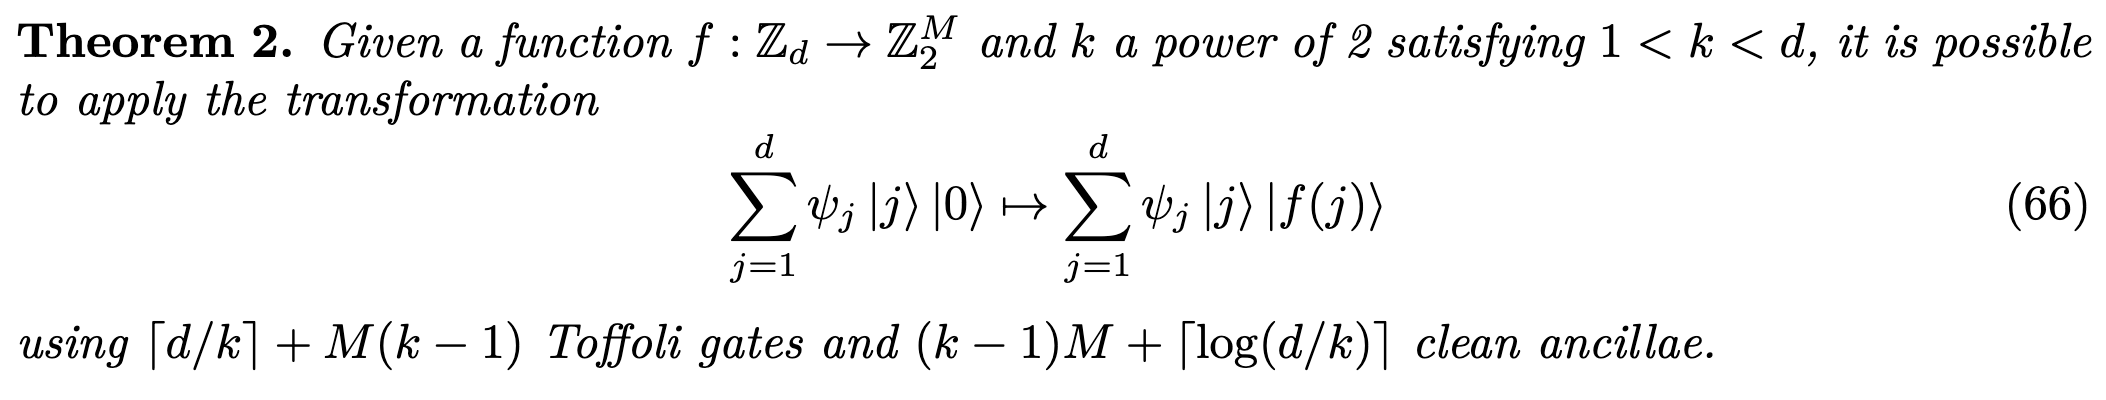

In [ ]:
g, sigma = qroam_symb_clean.call_graph()
show_counts_sigma(sigma)
# Total Toffoli counts obtained by summing up counts of T and T^{\daggar} gates.
show_counts_sigma({Toffoli(): (sigma[TGate()] + sigma[TGate().adjoint()]) / 4})